First read in the results from Runtime.hs

Each example is delimited with `__NEW_EXAMPLE__` 

In [26]:
from pathlib import Path
from matplotlib import pyplot as plt
import re
import pandas as pd
import numpy as np
import matplotlib
out_dir = Path("results")
out_dir.mkdir(exist_ok=True)

raw_results = Path("results.txt").read_text()
raw_results = raw_results.split("__START__")[-1].split("__END__")[0]
raw_results = raw_results.split("__NEW_EXAMPLE__")[1:]

In [27]:
progs= {}
for f in list(Path("examples").glob("*")):
    progs[f.read_text().strip()] = 
expected_num_examples = len()
print(f"{len(raw_results)} examples found, expected {expected_num_examples}")


50 examples found, expected 50


Each Example has:
* `SIZE_ORIG`-> The number of AST Nodes in the original program
* `IN`-> The original program
* `SYNTH`-> The synthesized program or "ERROR" if it failed
* `SIZE_SYNTH`-> Number of AST nodes in the final synthesized program.
* `TIME` -> The amount of time it took to run 

In [28]:
def parse_example_results(example_str):
    match = re.search(
        r"SIZE_ORIG:([0-9]+)\s+IN:([\s\S]+)SYNTH:([\s\S]+)SIZE_SYNTH:([\s\S]+)TIME:(.+)",
        flags=re.MULTILINE,
        string=example_str,
    )
    assert match is not None
    size_org = int(match.group(1).strip())
    prog = match.group(2).strip()

    has_hole = "{|" in prog
    synth = match.group(3).strip()
    failed = synth == "ERROR"
    if failed:
        size_synth = -1
    else:
        size_synth = int(match.group(4).strip())
    time, unit = match.group(5).strip().split()
    time = float(time)
    if unit == "us":
        time /= 1000

    return {
            "has_hole": has_hole,
            "failed": failed,
            "size_orig": size_org,
            "program": prog,
            "synthesized": synth,
            "size_synth": size_synth,
            "time": time,
        }
    


results = list(map(parse_example_results, raw_results))
df = pd.DataFrame(results)
df_passed = df[(df["has_hole"]) & (~df["failed"])]
print("Passing:")
print(f"\tMean Time: {df_passed['time'].mean():0.2f} (+/-{df_passed['time'].std():0.2f})")
print(f"\tMean Size: {df_passed['size_synth'].mean():0.2f} (+/-{df_passed['size_synth'].std():0.2f})")
nodes_added = df_passed["size_synth"] - df_passed["size_orig"]
print(f"\tMean Nodes Added: {nodes_added.mean():0.2f} (+/-{nodes_added.std():0.2f})")
failed = df[df["failed"]]
print("Failed:")
print(f"\tMean Time: {failed['time'].mean():0.2f} (+/-{failed['time'].std():0.2f})")



Passing:
	Mean Time: 0.36 (+/-1.34)
	Mean Size: 9.78 (+/-3.85)
	Mean Nodes Added: 4.70 (+/-3.00)
Failed:
	Mean Time: 165.32 (+/-233.41)


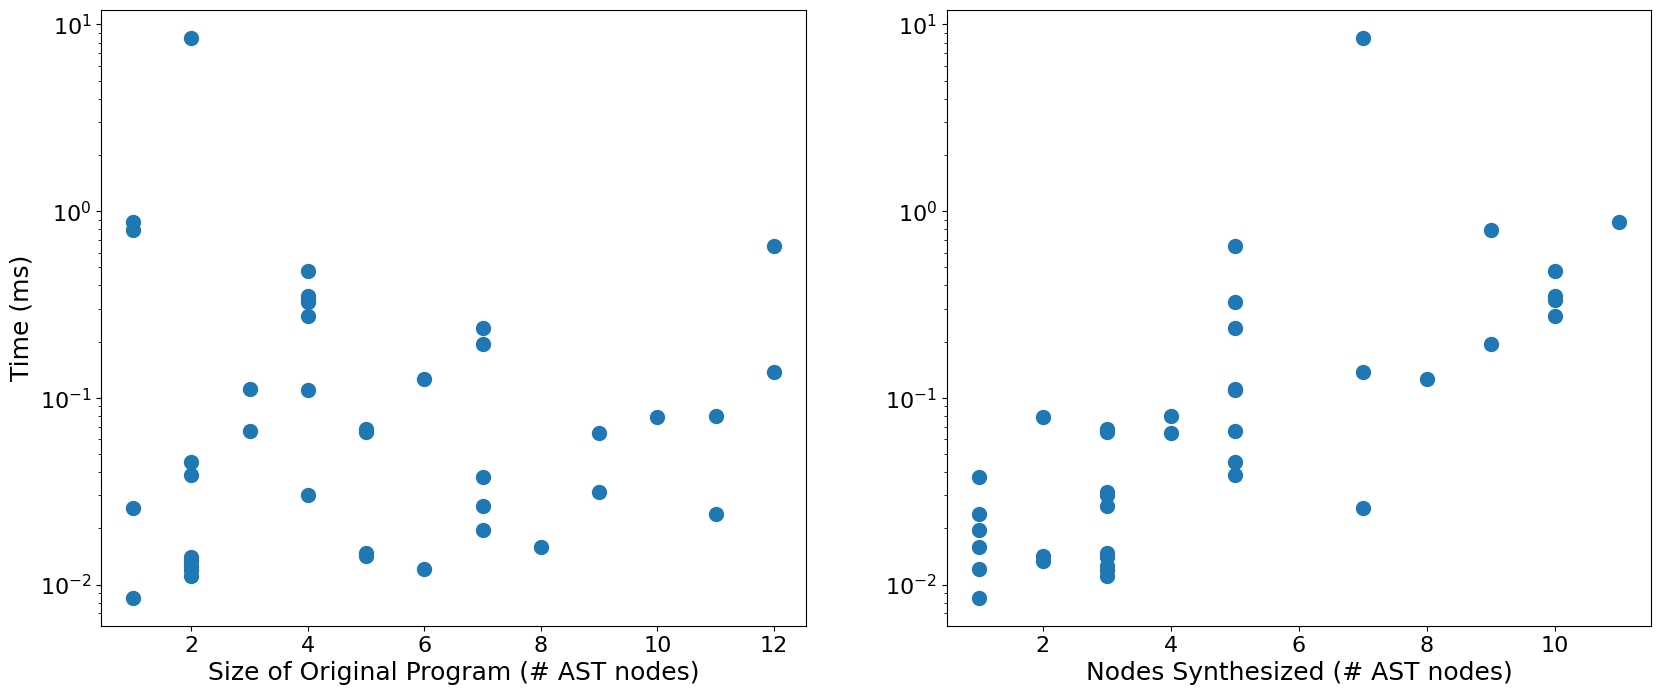

In [29]:
font = {'size': 16}

matplotlib.rc('font', **font)
fig,ax = plt.subplots(1,2,figsize=(20, 8))
ax[0].plot(df_passed["size_orig"], df_passed["time"], "o",markersize=10 )
ax[0].set_xlabel("Size of Original Program (# AST nodes)",fontsize=18)
ax[0].set_ylabel("Time (ms)",fontsize=18)

ax[0].set_yscale("log")
ax[1].plot(df_passed["size_synth"]-df_passed['size_orig'], df_passed["time"], "o",markersize=10)
ax[1].set_xlabel("Nodes Synthesized (# AST nodes)",fontsize=18)
# ax[0].set_ylabel("Time to synthesize (ms)")
ax[1].set_yscale("log")

In [25]:
df_passed.sort_values(by='time', ascending=False).head(10) 

,has_hole,failed,size_orig,program,synthesized,size_synth,time
11,True,False,4,lambda a:Int.lambda b:Bool.lambda c: (Int*Bool...,lambda a : Int. lambda b : Bool. lambda c : In...,11,248.8000
15,True,False,2,lambda f:Bool*Int->(Int*Int)*Bool.lambda g:Int...,lambda f : (Bool * Int) -> ((Int * Int) * Bool...,9,11.4100
17,True,False,2,lambda p:Int*Bool.lambda f:(Bool*Int)->(Int->B...,lambda p : Int * Bool. lambda f : (Bool * Int)...,9,8.6600
9,True,False,1,lambda a:Int.{|(Int*Int)*(Int*((Int*Int)*Int))|},"lambda a : Int. ((a, a), (a, ((a, a), a)))",12,0.6195
10,True,False,1,lambda a:Int.{|Int*(Int*((Int*Int)*Int))|},"lambda a : Int. (a, (a, ((a, a), a)))",10,0.6091
28,True,False,4,lambda f: Int->(Int*Int).lambda f1:(Int*Int)->...,lambda f : Int -> (Int * Int). lambda f1 : (In...,14,0.6075
12,True,False,4,lambda x: Bool. lambda f: Bool->Int*Bool.lambd...,lambda x : Bool. lambda f : Bool -> (Int * Boo...,14,0.4088
13,True,False,4,lambda x: Int.lambda f: Int->Bool.lambda f1:Bo...,lambda x : Int. lambda f : Int -> Bool. lambda...,14,0.3919
36,True,False,4,(lambda f1:(Int*(Int*Int))->Bool.(lambda f2: I...,lambda f1 : (Int * (Int * Int)) -> Bool. lambd...,9,0.3203
23,True,False,4,lambda f: Int->(Int*Int).lambda f1: (Int*Int)-...,lambda f : Int -> (Int * Int). lambda f1 : (In...,14,0.2749


In [30]:
df[~df["has_hole"]]

,has_hole,failed,size_orig,program,synthesized,size_synth,time
0,False,False,20,let f := lambda x:Int. callcc\n (lambda k: In...,let f := lambda x : Int. callcc (lambda k : In...,20,0.3506
1,False,False,20,let f := lambda x:Int. callcc\n (lambda k: In...,let f := lambda x : Int. callcc (lambda k : In...,20,0.0898
47,False,False,10,1 + callcc (lambda k: Int->Void. 2 + abort Int...,1 + (callcc (lambda k : Int -> Void. 2 + (abor...,10,0.0315
48,False,False,4,(if true then 1 else 2),if true then 1 else 2,4,0.0123
49,False,False,9,(((1 + 2) - 4) * (0 - 1)),((1 + 2) - 4) * (0 - 1),9,0.0158
